In [1]:
from bayes_opt import BayesianOptimization
import numpy as np
from bayes_opt import UtilityFunction
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import mlab
from matplotlib import gridspec
%matplotlib inline
def unique_rows(a):
    """
    A functions to trim repeated rows that may appear when optimizing.
    This is necessary to avoid the sklearn GP object from breaking

    :param a: array to trim repeated rows from

    :return: mask of unique rows
    """

    # Sort array and kep track of where things should go back to
    order = np.lexsort(a.T)
    reorder = np.argsort(order)

    a = a[order]
    diff = np.diff(a, axis=0)
    ui = np.ones(len(a), 'bool')
    ui[1:] = (diff != 0).any(axis=1)
    return ui[reorder]

In [2]:
import time
def target(x, y):
    a = np.exp(-( (x - 2)**2/0.7 + (y - 4)**2/1.2) + (x - 2)*(y - 4)/1.6 )
    b = np.exp(-( (x - 4)**2/3 + (y - 2)**2/2.) )
    c = np.exp(-( (x - 4)**2/0.5 + (y - 4)**2/0.5) + (x - 4)*(y - 4)/0.5 )
    d = np.sin(3.1415 * x)
    e = np.exp(-( (x - 5.5)**2/0.5 + (y - 5.5)**2/.5) )
    time.sleep(0.03)
    return 2*a + b - c + 0.17 * d + 2*e

2.0640981425835188
-0.8866078616271235


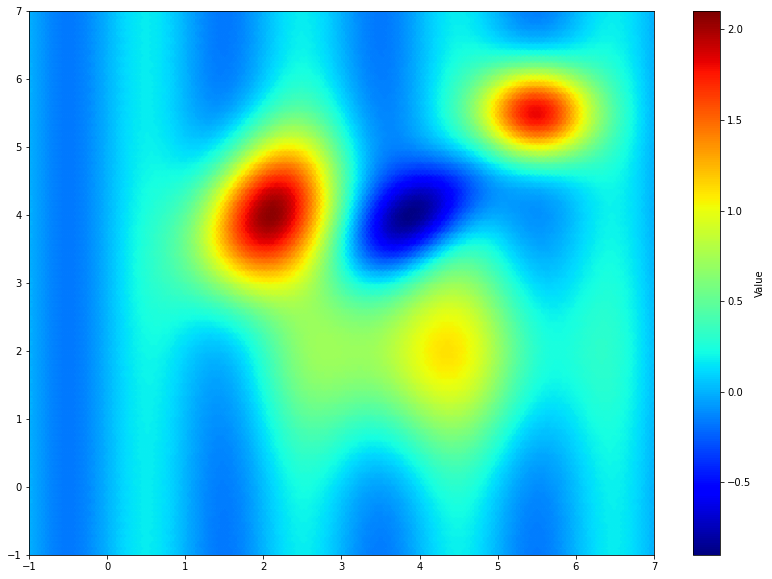

In [3]:
n = 1e5
x = y = np.linspace(-1, 7, 300)
X, Y = np.meshgrid(x, y)
x = X.ravel()
y = Y.ravel()
X = np.vstack([x, y]).T[:, [1, 0]]
z = target(x, y)
print(max(z))
print(min(z))
fig, axis = plt.subplots(1, 1, figsize=(14, 10))
gridsize=150
im = axis.hexbin(x, y, C=z, gridsize=gridsize, cmap=cm.jet, bins=None, vmin=-0.9, vmax=2.1)
axis.axis([x.min(), x.max(), y.min(), y.max()])
cb = fig.colorbar(im, )
cb.set_label('Value')
utility_function = UtilityFunction(kind="ucb", kappa=10, xi=0)

In [4]:
def posterior(bo, X):
    x_obs = np.array([[res["params"]["x"],res["params"]["y"]] for res in bo.res])
    y_obs = np.array([res["target"] for res in bo.res])
    ur = unique_rows(x_obs)
    bo._gp.fit(x_obs[ur], y_obs[ur])
    mu, sigma2 = bo._gp.predict(X, return_std=True)
    
    return mu, np.sqrt(sigma2), utility_function.utility(X, bo._gp, y_obs.max())

In [5]:

def plot_2d(name=None):
    mu, s, ut = posterior(bo, X)
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    gridsize=150
    x_obs = np.array([[res["params"]["x"],res["params"]["y"]] for res in bo.res])

    # fig.suptitle('Bayesian Optimization in Action', fontdict={'size':30})

    # GP regression output
    ax[0][0].set_title('Gausian Process Predicted Mean', fontdict={'size':15})
    im00 = ax[0][0].hexbin(x, y, C=mu, gridsize=gridsize, cmap=cm.jet, bins=None, vmin=-0.9, vmax=2.1)
    ax[0][0].axis([x.min(), x.max(), y.min(), y.max()])
    ax[0][0].plot(x_obs[:, 1], x_obs[:, 0], 'D', markersize=4, color='k', label='Observations')

    ax[0][1].set_title('Target Function', fontdict={'size':15})
    im10 = ax[0][1].hexbin(x, y, C=z, gridsize=gridsize, cmap=cm.jet, bins=None, vmin=-0.9, vmax=2.1)
    ax[0][1].axis([x.min(), x.max(), y.min(), y.max()])
    ax[0][1].plot(x_obs[:, 1], x_obs[:, 0], 'D', markersize=4, color='k')


    ax[1][0].set_title('Gausian Process Variance', fontdict={'size':15})
    im01 = ax[1][0].hexbin(x, y, C=s, gridsize=gridsize, cmap=cm.jet, bins=None, vmin=0, vmax=1)
    ax[1][0].axis([x.min(), x.max(), y.min(), y.max()])

    ax[1][1].set_title('Acquisition Function', fontdict={'size':15})
    im11 = ax[1][1].hexbin(x, y, C=ut, gridsize=gridsize, cmap=cm.jet, bins=None, vmin=0, vmax=8)

    np.where(ut.reshape((300, 300)) == ut.max())[0]
    np.where(ut.reshape((300, 300)) == ut.max())[1]

    ax[1][1].plot([np.where(ut.reshape((300, 300)) == ut.max())[1]/50., 
                   np.where(ut.reshape((300, 300)) == ut.max())[1]/50.], 
                  [0, 6], 
                  'k-', lw=2, color='k')

    ax[1][1].plot([0, 6],
                  [np.where(ut.reshape((300, 300)) == ut.max())[0]/50., 
                   np.where(ut.reshape((300, 300)) == ut.max())[0]/50.], 
                  'k-', lw=2, color='k')

    ax[1][1].axis([x.min(), x.max(), y.min(), y.max()])

    for im, axis in zip([im00, im10, im01, im11], ax.flatten()):
        cb = fig.colorbar(im, ax=axis)
        # cb.set_label('Value')

    if name is None:
        name = '_'

    plt.tight_layout()

    # Save or show figure?
    # fig.savefig('bo_eg_' + name + '.png')
    plt.show()
    plt.close(fig)

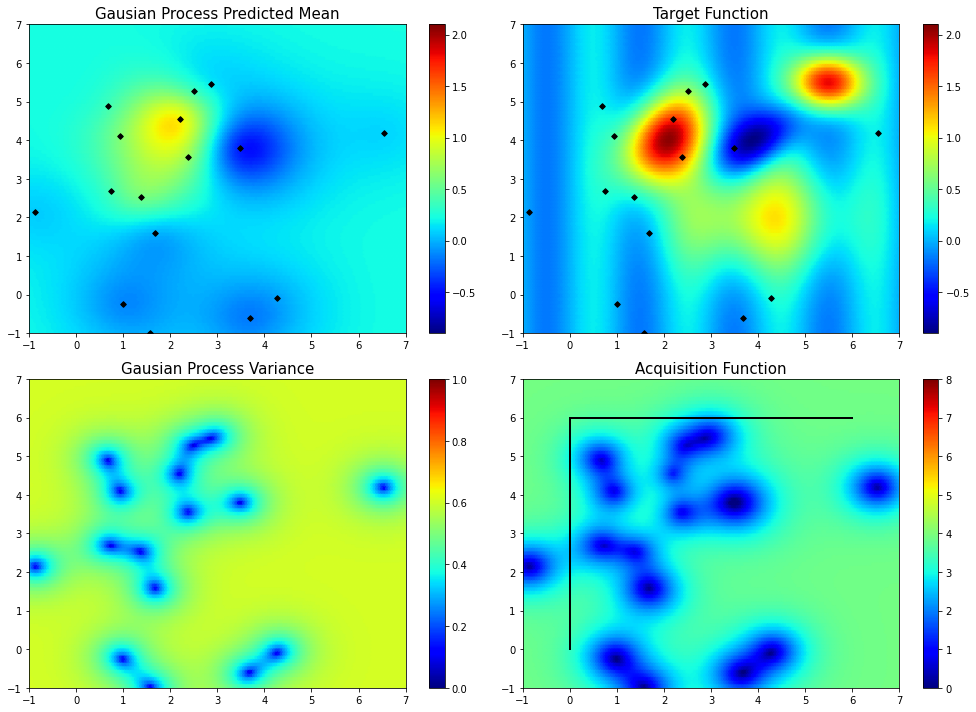

10 	 time:  5.136338472366333


In [8]:

bo = BayesianOptimization(target, {'x': (-1,7), 'y': (-1, 7)},
        random_state=27,
        n_restarts_optimizer=2,
        batch_size=16
                         )

next_point = bo.suggest(utility_function)
_target = target(**next_point)
bo.register(params=next_point, target=_target)
plot_2d("{:03}".format(len(bo.res)))


# Turn interactive plotting off
plt.ioff()
import time
for i in range(10):
    s=time.time()
    next_point = bo.suggest(utility_function)
    _target = target(**next_point)
    bo.register(params=next_point, target=_target)
d=time.time()
print(i+1,'\t time: ',d-s)
#     plot_2d("{:03}".format(len(bo.res)))